In [54]:
import pandas as pd
import numpy as np

In [55]:
import os
os.getcwd()

'/Users/dgarhdez/Desktop/IE/ie-mbd-pda2/SESSION_07'

In [56]:
wine = pd.read_csv("./data/winemag-data_first150k.csv")

In [57]:
wine.drop('Unnamed: 0', axis=1, inplace=True)

wine.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


### Dealing with missing values

In [58]:
wine.isna().mean()

country        0.000033
description    0.000000
designation    0.303021
points         0.000000
price          0.090737
province       0.000033
region_1       0.166037
region_2       0.596151
variety        0.000000
winery         0.000000
dtype: float64

The main offenders missing-values.wise are:
* `designation`
* `price`
* `province`
* `region_1`
* `region_2`

#### Missing values in `designation`

Let's assume that `designation` is a categorical variable. We can use the `fillna` method to fill the missing values with the most frequent value in the column.
```python
wine['designation'].fillna("missing", inplace=True)
```

But first, let's create a new column `designation_missing` that indicates whether the value was missing or not.
```python
wine['designation_missing'] = 1 * wine['designation'].isna()
```

In [59]:
wine['designation_missing'] = 1 * wine['designation'].isna()
wine["designation"] = wine['designation'].fillna("missing")

#### Missing values in `price`
We can see that the `price` variable is a float. We can fill the missing values in many ways:
* Fill with the mean
* Fill with the median
* Interpolate the values
* Train a model that predicts the price based on the other variables
* ...

Let's check the distribution of the `price` variable first


<AxesSubplot:>

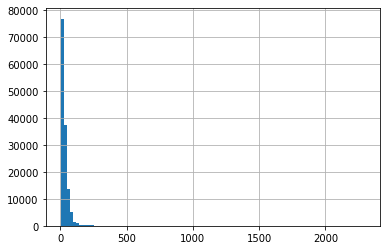

In [60]:
import matplotlib.pyplot as plt

wine["price"].hist(bins=100)

We can see that the distribution is skewed to the right. We can fill the missing values with the median, which is more robust to outliers.

Also, if using Linear Regression, we should use the log of the price, since it will convert the distribution to a normal-ish distribution. We can use the `np.log` function to do that.
```python
wine["log_price"] = np.log(wine["price"])
```

In [61]:
wine["price_missing"] = 1 * wine["price"].isna()
wine["price"] = wine["price"].fillna(wine["price"].median())

#### Missing values in `province`

Will drop those rows, since there are only 5 missing values.

#### Missing values in `region_1` and `region_2`

This two variables are also categorical. We can fill the missing values with "missing" in the column.

In [62]:
# region_1
wine['region_1_missing'] = 1 * wine['region_1'].isna()
wine["region_1"] = wine['region_1'].fillna("missing")

# region_2
wine['region_2_missing'] = 1 * wine['region_2'].isna()
wine["region_2"] = wine['region_2'].fillna("missing")

#### Dropping the rest of the missing values

In [63]:
wine = (
    wine
    .dropna(subset=['province'])
    .reset_index(drop=True)
)

print(wine.isna().mean())
print(wine.shape)

country                0.0
description            0.0
designation            0.0
points                 0.0
price                  0.0
province               0.0
region_1               0.0
region_2               0.0
variety                0.0
winery                 0.0
designation_missing    0.0
price_missing          0.0
region_1_missing       0.0
region_2_missing       0.0
dtype: float64
(150925, 14)


### Dealing with categorical variables

Let's use `LabelEncoder` to encode the categorical variables. We can use the `get_dummies` method to create dummy variables for the categorical variables. Since we are going to use a tree-based model, we don't need to create dummy variables.

In [64]:
from sklearn.preprocessing import LabelEncoder

cat_columns = [col for col in wine.select_dtypes(include=['object']).columns if col!="description"]

for cat_col in cat_columns:
    print(cat_col, f"{len(wine[cat_col].unique())} categories")
    wine[cat_col] = LabelEncoder().fit_transform(wine[cat_col])

country 48 categories
designation 30619 categories
province 455 categories
region_1 1237 categories
region_2 19 categories
variety 632 categories
winery 14809 categories


We can see that for `designation` and `winery` we have a lot of unique values. We can work with them as they are, but doing some target encoding might improve the performance of the model.
* `designation`: We can use the mean of the `price` for each `designation` to encode the variable.
* `winery`: We can use the mean of the `price` for each `winery` to encode the variable.

With this, the column will not represent a category anymore, but a number.

In [65]:
wine["designation"] = wine.groupby("designation")["price"].transform("mean")
wine["winery"] = wine.groupby("winery")["price"].transform("mean")

wine[["designation", "winery"]].head()

,designation,winery
0,177.500000,126.333333
1,110.000000,57.500000
2,90.000000,78.800000
3,33.230741,45.202703
4,66.000000,47.500000


### Correlations

Let's check the correlations between the variables. We can use the `corr` method to get the correlations between the variables.

In [66]:
wine_corr = wine.corr()

wine_corr["points"].sort_values(ascending=False)

/var/folders/kn/gt9ggj051wdfjnfqv8xjl8qh0000gn/T/ipykernel_62973/395391247.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  wine_corr = wine.corr()


points                 1.000000
winery                 0.431779
price                  0.429703
designation            0.366311
price_missing          0.098722
region_2               0.046325
province               0.042154
region_2_missing       0.006418
country               -0.027086
region_1              -0.041073
region_1_missing      -0.051494
variety               -0.069436
designation_missing   -0.159978
Name: points, dtype: float64

With these results, we can only say that there is a correlation between `points` and `price` (0.43). We can see that the correlation is not very strong, but it is there.

The rest of the variables are numbers that represent categories, therefore ANY correlation between them is not very meaningful, since the choice of the category is arbitrary.

### Dealing with text

Let's use `TfidfVectorizer` to create a matrix with the TF-IDF values for each word in the `description` column.
* `max_features`: We can use the `max_features` parameter to limit the number of features. We can use the `get_feature_names` method to get the names of the features.
* `ngram_range`: We can use the `ngram_range` parameter to create features with more than one word. For example, if we use `(1, 2)`, we will create features with one word and two words.
* `stop_words`: We can use the `stop_words` parameter to remove common words that don't add much information to the model.

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=500,  # keep only the top 5000 most frequent words
    stop_words="english", # remove stop words from the vocabulary
    ngram_range=(1, 2) # unigrams and bigrams, cake, carrot, and carrot cake
)

# vectorized
tfidf_desc = tfidf.fit_transform(wine["description"])

# add column namesto matrix as a dataframe
tfidf_desc = pd.DataFrame(tfidf_desc.toarray(), columns=tfidf.get_feature_names_out())
print(tfidf_desc.shape)

(150925, 500)


In [74]:
tfidf_desc

,10,100,15,2010,2012,2015,accented,accents,acid,acidic,...,wood,wrapped,year,years,yellow,young,zest,zesty,zin,zinfandel
0,0.0,0.264697,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.350987,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.243964,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150920,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
150921,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
150922,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
150923,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
wine_x = wine.drop(["description", "points"], axis=1)
y = wine["points"]
x = pd.concat([wine_x, tfidf_desc], axis=1)

print(x.shape)
print(y.shape)

(150925, 512)
(150925,)


### Machine Learning part

Let's use a Random Forest Regressor to predict the points of the wine.

1. We need to split the data into train and test sets. We can use the `train_test_split` method to do that.
2. We need to train the model. We can use the `fit` method to do that.
3. We need to predict the points for the test set. We can use the `predict` method to do that.
4. We need to evaluate the model. We can use the `mean_squared_error` and `r2_score` to do that.
5. We can use the `feature_importances_` attribute to get the feature importances, save them in a DataFrame and sort them by the importance.

In [ ]:
# Homework